# Overview

This project analyses the 2020 used car data to identify what features have a strong relationship with resale price of used car. The analysis also looks to dertermine if the model can be used to accurately predict the resale price. 

# Data Understanding and Preparation

In [1]:
# Import Standard Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.formula.api import ols


sales = pd.read_csv('data/car data.csv')
pd.options.display.float_format = '{:,.0f}'.format
sales.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3,6,27000,Petrol,Dealer,Manual,0
1,sx4,2013,5,10,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7,10,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,3,4,5200,Petrol,Dealer,Manual,0
4,swift,2014,5,7,42450,Diesel,Dealer,Manual,0


In [2]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [3]:
#check for any NAN value
sales.isna().sum()

Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

Based on the above, Waterfront and Yr Renovated require data cleasning 

In [4]:
#add "age" column 
sales['Age']=[2020] - sales['Year']
sales.drop(['Year','Car_Name'],axis=1,inplace = True)
sales.head()

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Age
0,3,6,27000,Petrol,Dealer,Manual,0,6
1,5,10,43000,Diesel,Dealer,Manual,0,7
2,7,10,6900,Petrol,Dealer,Manual,0,3
3,3,4,5200,Petrol,Dealer,Manual,0,9
4,5,7,42450,Diesel,Dealer,Manual,0,6


In [5]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Selling_Price  301 non-null    float64
 1   Present_Price  301 non-null    float64
 2   Kms_Driven     301 non-null    int64  
 3   Fuel_Type      301 non-null    object 
 4   Seller_Type    301 non-null    object 
 5   Transmission   301 non-null    object 
 6   Owner          301 non-null    int64  
 7   Age            301 non-null    int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 18.9+ KB


# Outlier Detection and Removal

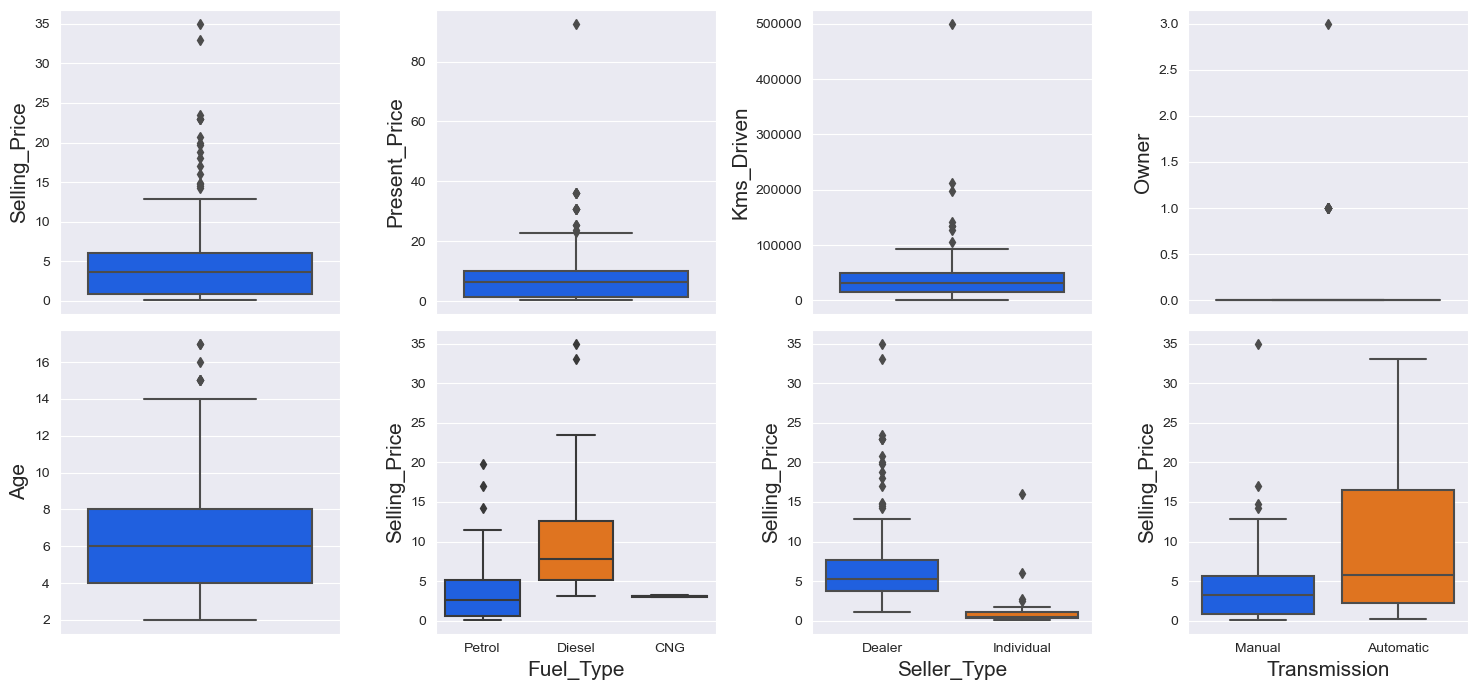

In [6]:
#outlier detection
import seaborn as sns
sns.set_style('darkgrid')
colors = ['#0055ff', '#ff7000', '#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))

OrderedCols = np.concatenate([sales.select_dtypes(exclude='object').columns.values, 
                              sales.select_dtypes(include='object').columns.values])

fig, ax = plt.subplots(2, 4, figsize=(15,7),dpi=100)

for i,col in enumerate(OrderedCols):
    x = i//4
    y = i%4
    if i<5:
        sns.boxplot(data=sales, y=col, ax=ax[x,y])
        ax[x,y].yaxis.label.set_size(15)
    else:
        sns.boxplot(data=sales, x=col, y='Selling_Price', ax=ax[x,y])
        ax[x,y].xaxis.label.set_size(15)
        ax[x,y].yaxis.label.set_size(15)

plt.tight_layout()    
plt.show()

In [7]:
outliers_indexes = []
target = 'Selling_Price'

for col in sales.select_dtypes(include='object').columns:
    for cat in sales[col].unique():
        df1 = sales[sales[col] == cat]
        q1 = df1[target].quantile(0.25)
        q3 = df1[target].quantile(0.75)
        iqr = q3-q1
        maximum = q3 + (1.5 * iqr)
        minimum = q1 - (1.5 * iqr)
        outlier_samples = df1[(df1[target] < minimum) | (df1[target] > maximum)]
        outliers_indexes.extend(outlier_samples.index.tolist())
        
        
for col in sales.select_dtypes(exclude='object').columns:
    q1 = sales[col].quantile(0.25)
    q3 = sales[col].quantile(0.75)
    iqr = q3-q1
    maximum = q3 + (1.5 * iqr)
    minimum = q1 - (1.5 * iqr)
    outlier_samples = sales[(sales[col] < minimum) | (sales[col] > maximum)]
    outliers_indexes.extend(outlier_samples.index.tolist())
    
outliers_indexes = list(set(outliers_indexes))
print('{} outliers were identified, whose indices are:\n\n{}'.format(len(outliers_indexes), outliers_indexes))

38 outliers were identified, whose indices are:

[27, 37, 39, 50, 51, 52, 53, 54, 179, 184, 58, 59, 189, 62, 63, 64, 191, 66, 192, 196, 69, 193, 198, 201, 77, 205, 79, 80, 82, 84, 85, 86, 92, 93, 96, 97, 106, 241]


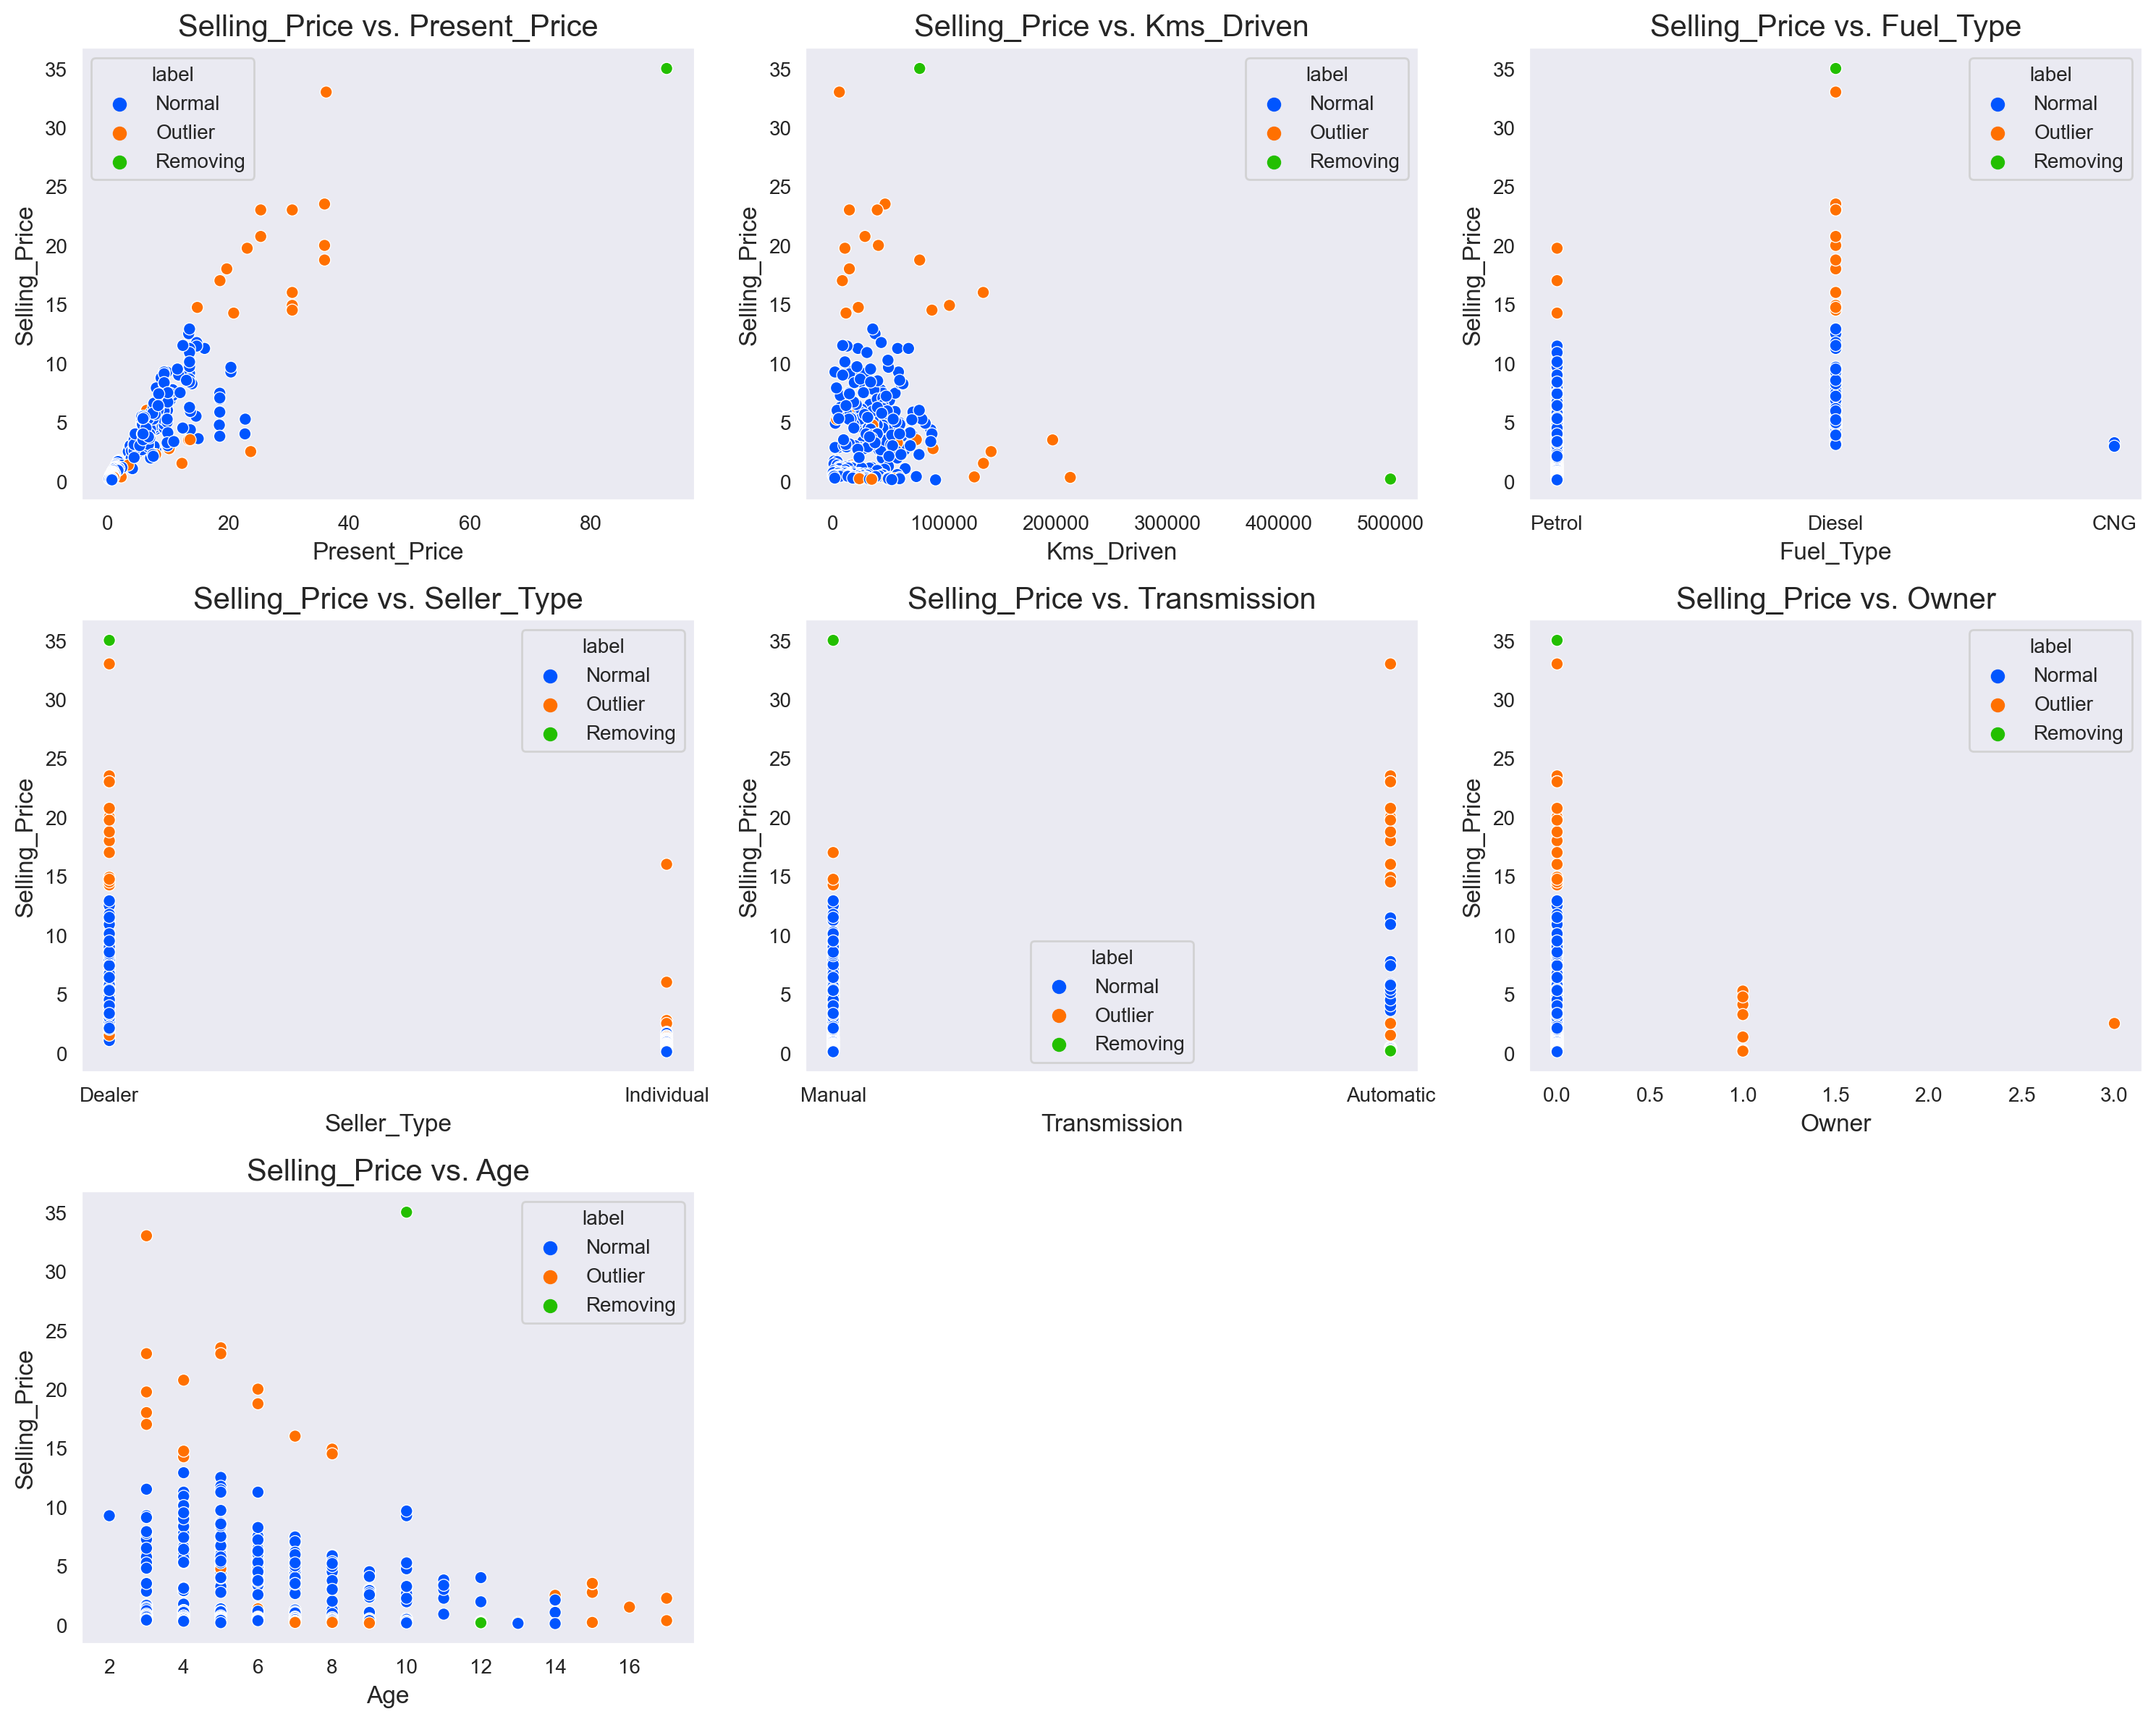

In [8]:
# Outliers Labeling
df1 = sales.copy()
df1['label'] = 'Normal'
df1.loc[outliers_indexes,'label'] = 'Outlier'

# Removing Outliers
removing_indexes = []
removing_indexes.extend(df1[df1[target]>33].index)
removing_indexes.extend(df1[df1['Kms_Driven']>400000].index)
df1.loc[removing_indexes,'label'] = 'Removing'

# Plot
target = 'Selling_Price'
features = sales.columns.drop(target)
colors = ['#0055ff','#ff7000','#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(nrows=3 ,ncols=3, figsize=(15,12), dpi=200)

for i in range(len(features)):
    x=i//3
    y=i%3
    sns.scatterplot(data=df1, x=features[i], y=target, hue='label', ax=ax[x,y])
    ax[x,y].set_title('{} vs. {}'.format(target, features[i]), size = 15)
    ax[x,y].set_xlabel(features[i], size = 12)
    ax[x,y].set_ylabel(target, size = 12)
    ax[x,y].grid()

ax[2, 1].axis('off')
ax[2, 2].axis('off')
plt.tight_layout()
plt.show()

In [9]:
df1 = sales.copy()
df1.drop(removing_indexes, inplace=True)
df1.reset_index(drop=True, inplace=True)

# Explore Variables

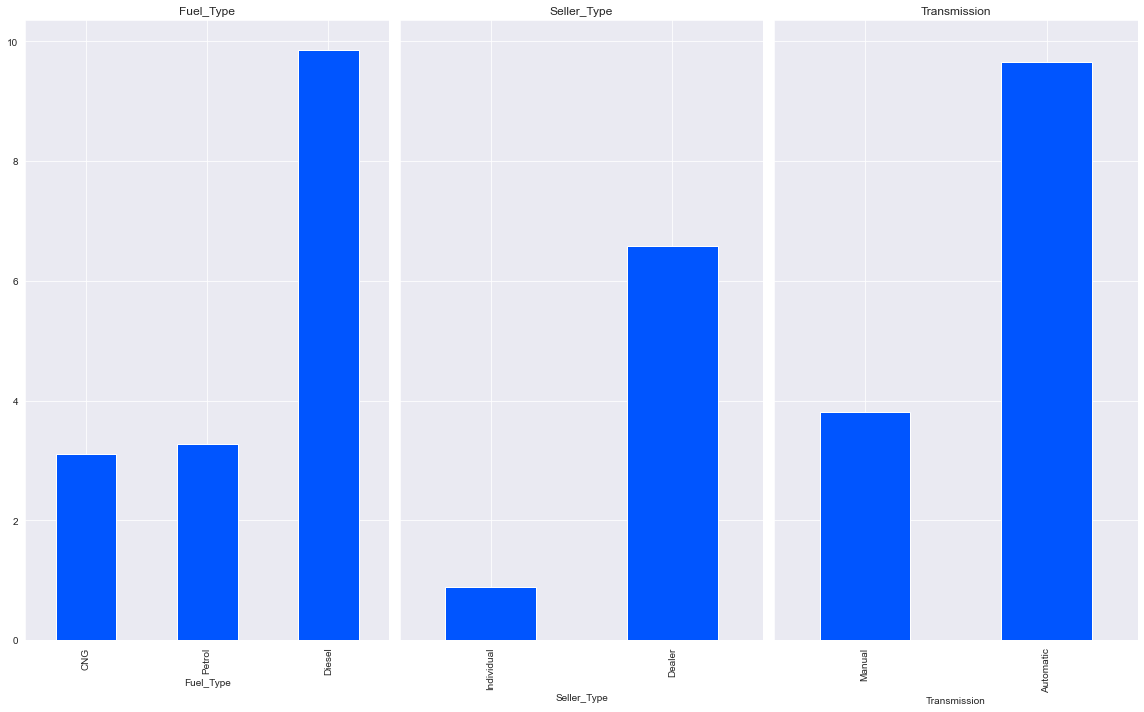

In [10]:
#Check categorical variables

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,10), sharey=True)

categoricals = ['Fuel_Type', 'Seller_Type', 'Transmission']

for col, ax in zip(categoricals, axes.flatten()):
    (df1.groupby(col)               # group values together by column of interest
         .mean()['Selling_Price']        # take the mean of the saleprice for each group
         .sort_values()              # sort the groups in ascending order
         .plot
         .bar(ax=ax))                # create a bar graph on the ax
    
    ax.set_title(col)                # Make the title the name of the column
    
fig.tight_layout()

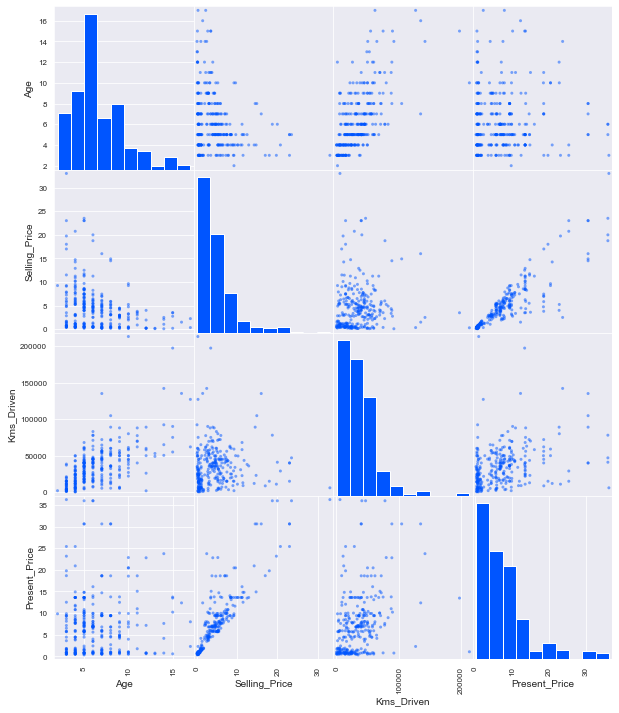

In [11]:
# check distribution of the continuous variables 
continuous = ['Age', 'Selling_Price', 'Kms_Driven','Present_Price']
df1_cont = df1[continuous]
pd.plotting.scatter_matrix(df1_cont, figsize=(10,12));

# Build Base Model

In [12]:
#create dummies: 
CatCols = ['Fuel_Type', 'Seller_Type', 'Transmission','Owner']
df1 = pd.get_dummies(df1, columns=CatCols, drop_first=True)
df1.head(5)

,Selling_Price,Present_Price,Kms_Driven,Age,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual,Owner_1,Owner_3
0,3,6,27000,6,0,1,0,1,0,0
1,5,10,43000,7,1,0,0,1,0,0
2,7,10,6900,3,0,1,0,1,0,0
3,3,4,5200,9,0,1,0,1,0,0
4,5,7,42450,6,1,0,0,1,0,0


In [13]:
X = df1.drop('Selling_Price', axis=1)
y = df1['Selling_Price']
import statsmodels.api as sm
X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Selling_Price   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     270.1
Date:                Sun, 26 Feb 2023   Prob (F-statistic):          4.51e-135
Time:                        16:45:28   Log-Likelihood:                -556.34
No. Observations:                 299   AIC:                             1133.
Df Residuals:                     289   BIC:                             1170.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      3.1561      1.206      2.616      0.009       0.781       5.531
Present_Price              0.5584      0.021     26.608      0.000       0.517       0.600
Kms_Driven             -2.348e-05   4.76e-06     -4.936      0.000   -3.28e-05   -1.41e-05
Age                       -0.2981      0.044     -6.848      0.000      -0.384      -0.212
Fuel_Type_Diesel           1.9769      1.149      1.721      0.086      -0.284       4.238
Fuel_Type_Petrol           0.3510      1.128      0.311      0.756      -1.870       2.572
Seller_Type_Individual    -0.4630      0.252     -1.834      0.068      -0.960       0.034
Transmission_Manual       -0.5476      0.321     -1.708      0.089      -1.179       0.084
Owner_1                    0.3925      0.518      0.758      0.449      -0.626       1.411
Owner_3                   -6.2870      1.678     -3.747      0.000      -9.589      -2.985
==============================================================================
Omnibus:                       54.596   Durbin-Watson:                   1.857
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              393.860
Skew:                           0.473   Prob(JB):                     2.98e-86
Kurtosis:                       8.543   Cond. No.                     9.68e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.68e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

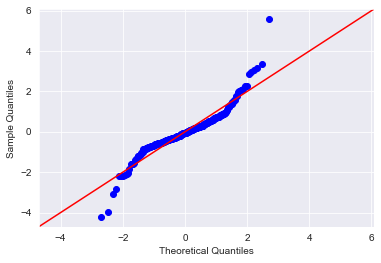

In [14]:
#Check Residuals 
import scipy.stats as stats
residuals = model.resid
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
plt.show()

We noted that the continuous variables were right skewed. 

In [15]:
# log features
log_names = [f'{column}_log' for column in df1_cont.columns]

df2_log = np.log(df1_cont)
df2_log.columns = log_names

df2_log.head()

,Age_log,Selling_Price_log,Kms_Driven_log,Present_Price_log
0,2,1,10,2
1,2,2,11,2
2,1,2,9,2
3,2,1,9,1
4,2,2,11,2


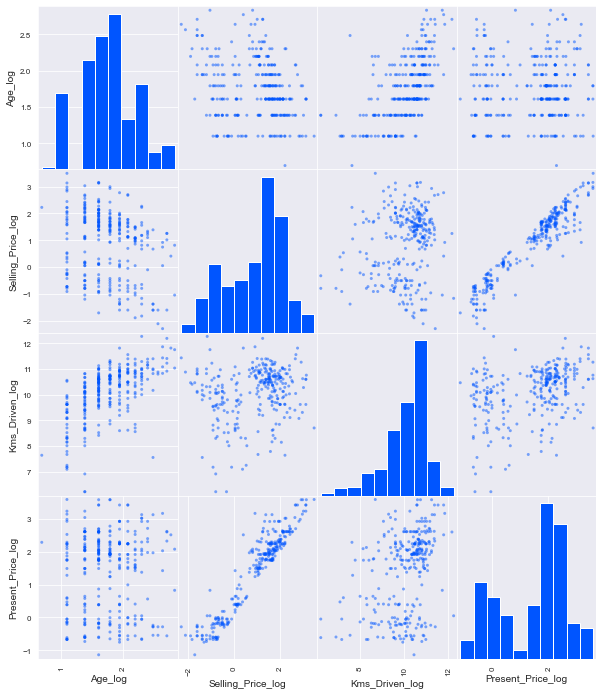

In [16]:
pd.plotting.scatter_matrix(df2_log, figsize=(10,12));

In [17]:
df3 = pd.concat([df2_log,df1], axis=1)
df3.drop(['Age', 'Selling_Price', 'Kms_Driven','Present_Price'],axis=1,inplace = True)
df3.head()

,Age_log,Selling_Price_log,Kms_Driven_log,Present_Price_log,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual,Owner_1,Owner_3
0,2,1,10,2,0,1,0,1,0,0
1,2,2,11,2,1,0,0,1,0,0
2,1,2,9,2,0,1,0,1,0,0
3,2,1,9,1,0,1,0,1,0,0
4,2,2,11,2,1,0,0,1,0,0


In [18]:
#rerun the model 
X = df3.drop('Selling_Price_log', axis=1)
y = df3['Selling_Price_log']

In [19]:
import statsmodels.api as sm
X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Selling_Price_log   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1316.
Date:                Sun, 26 Feb 2023   Prob (F-statistic):          8.66e-229
Time:                        16:45:29   Log-Likelihood:                 66.566
No. Observations:                 299   AIC:                            -113.1
Df Residuals:                     289   BIC:                            -76.13
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1.3081      0.201      6.496      0.000       0.912       1.704
Age_log                   -0.6796      0.036    -18.934      0.000      -0.750      -0.609
Kms_Driven_log            -0.0542      0.016     -3.311      0.001      -0.086      -0.022
Present_Price_log          0.9071      0.023     40.288      0.000       0.863       0.951
Fuel_Type_Diesel           0.2464      0.143      1.727      0.085      -0.034       0.527
Fuel_Type_Petrol           0.0799      0.141      0.568      0.570      -0.197       0.357
Seller_Type_Individual    -0.2261      0.053     -4.278      0.000      -0.330      -0.122
Transmission_Manual        0.0270      0.036      0.750      0.454      -0.044       0.098
Owner_1                   -0.1788      0.064     -2.778      0.006      -0.305      -0.052
Owner_3                   -0.6812      0.212     -3.218      0.001      -1.098      -0.265
==============================================================================
Omnibus:                       19.284   Durbin-Watson:                   1.754
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.283
Skew:                          -0.414   Prob(JB):                     1.61e-07
Kurtosis:                       4.351   Cond. No.                         241.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

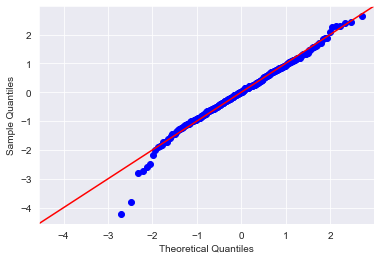

In [20]:
#Check the distribution of residuals 

import scipy.stats as stats
residuals = model.resid
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
plt.show()

In [21]:
#drop ages and check if it has improved the model R square 
df3= df3.drop(['Fuel_Type_Diesel','Fuel_Type_Petrol','Transmission_Manual'], axis=1)
df3.head()

,Age_log,Selling_Price_log,Kms_Driven_log,Present_Price_log,Seller_Type_Individual,Owner_1,Owner_3
0,2,1,10,2,0,0,0
1,2,2,11,2,0,0,0
2,1,2,9,2,0,0,0
3,2,1,9,1,0,0,0
4,2,2,11,2,0,0,0


In [22]:
#rerun the model 
X = df3.drop('Selling_Price_log', axis=1)
y = df3['Selling_Price_log']
X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Selling_Price_log   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1824.
Date:                Sun, 26 Feb 2023   Prob (F-statistic):          3.73e-228
Time:                        16:45:29   Log-Likelihood:                 53.515
No. Observations:                 299   AIC:                            -93.03
Df Residuals:                     292   BIC:                            -67.13
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1.2679      0.141      8.990      0.000       0.990       1.545
Age_log                   -0.7096      0.037    -19.286      0.000      -0.782      -0.637
Kms_Driven_log            -0.0369      0.017     -2.220      0.027      -0.070      -0.004
Present_Price_log          0.9365      0.021     43.620      0.000       0.894       0.979
Seller_Type_Individual    -0.1941      0.053     -3.649      0.000      -0.299      -0.089
Owner_1                   -0.1697      0.067     -2.540      0.012      -0.301      -0.038
Owner_3                   -0.8130      0.218     -3.730      0.000      -1.242      -0.384
==============================================================================
Omnibus:                       21.804   Durbin-Watson:                   1.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.130
Skew:                          -0.500   Prob(JB):                     1.05e-07
Kurtosis:                       4.257   Cond. No.                         195.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

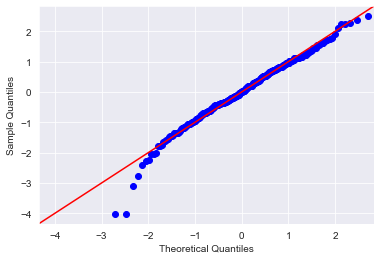

In [23]:
import scipy.stats as stats
residuals = model.resid
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
plt.show()

QQ plot shows that the normality assumption of the residuals seems fulfilled.

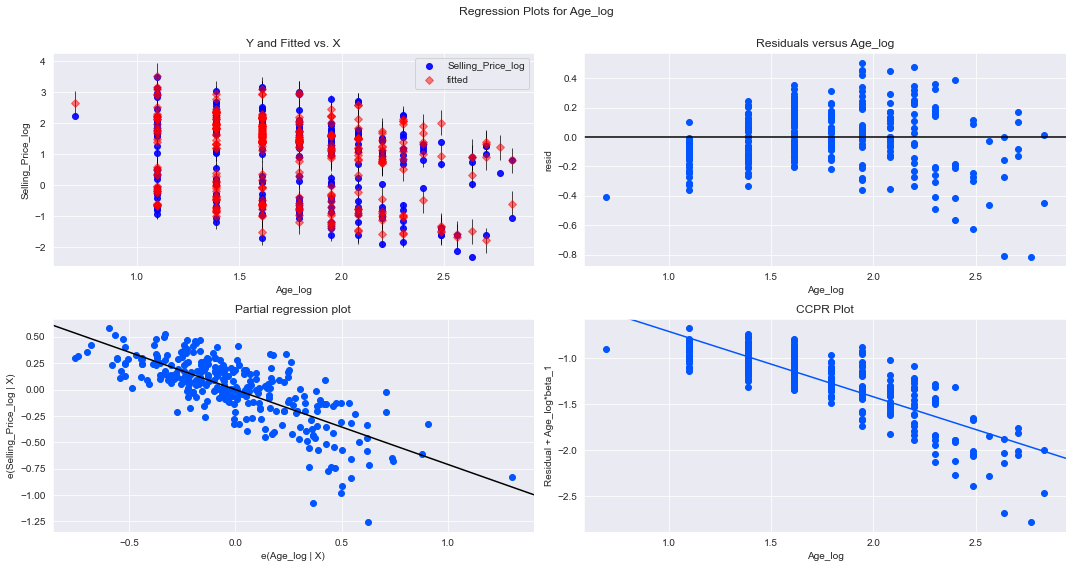

In [37]:
#check for Homoscedasticity

fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "Age_log", fig=fig)
plt.show()

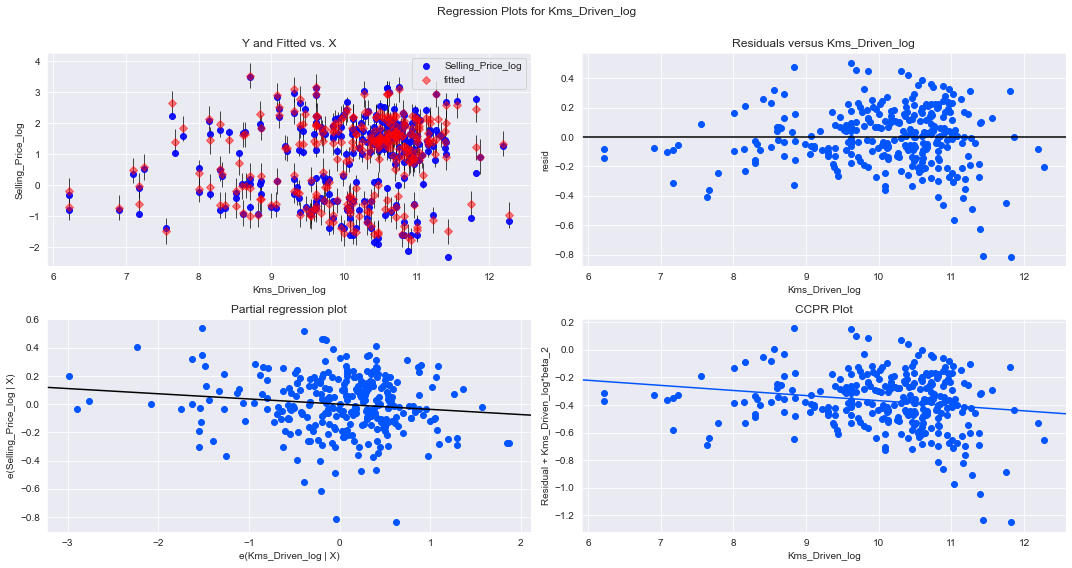

In [39]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "Kms_Driven_log", fig=fig)
plt.show()

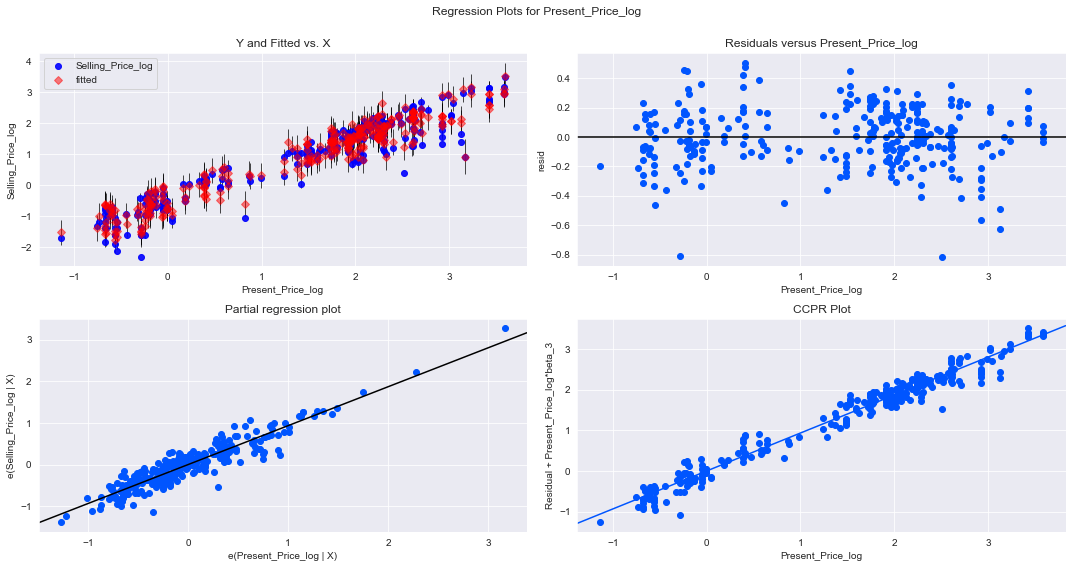

In [41]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "Present_Price_log", fig=fig)
plt.show()

Based on the above, the assumption of Homoscedasticity appears to be met.

Train-Test Split:
Perform a train-test split with a test set of 20% and a random state of 4.

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [25]:
#Fit a linear regression model on the training set

from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)


LinearRegression()

In [26]:
#Generate Predictions on Training and Test Sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [27]:
#Calculate the Mean Squared Error (MSE)
from sklearn.metrics import mean_squared_error
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error: ', test_mse)

Train Mean Squared Error: 0.04389259098323844
Test Mean Squared Error:  0.029247365996622747


The difference between Test MSE and Train MSE is a little large(appx 33%)

In [28]:
# Import relevant modules and functions
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
# Scale the test set
X_test_scaled = scaler.transform(X_test)

poly= PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.fit_transform(X_test_scaled)

# Check the shape
np.shape(X_train_poly)

(239, 27)

In [29]:
#fit regression into the model: 
polyreg = LinearRegression()
polyreg.fit(X_train_poly, y_train)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression()

In [30]:
# Training set predictions
poly_train_predictions = polyreg.predict(X_train_poly)

# Test set predictions 
poly_test_predictions = polyreg.predict(X_test_poly)

In [31]:
#Calculate the Mean Squared Error (MSE)
from sklearn.metrics import mean_squared_error
poly_train_mse = mean_squared_error(y_train, poly_train_predictions)
poly_test_mse = mean_squared_error(y_test, poly_test_predictions)
print('Train Mean Squared Error:', poly_train_mse)
print('Test Mean Squared Error: ', poly_test_mse)

Train Mean Squared Error: 0.025801024134270403
Test Mean Squared Error:  0.03341965250967328


The variance between test and train mean squared error has imprved (now ~ 29%). The overvall error is very low. 

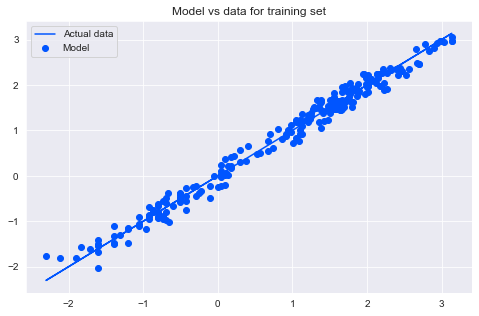

In [32]:
#Plot predictions for the training set against the actual data:
plt.figure(figsize=(8, 5))
plt.scatter(y_train, poly_train_predictions, label='Model')
plt.plot(y_train, y_train, label='Actual data')
plt.title('Model vs data for training set')
plt.legend();

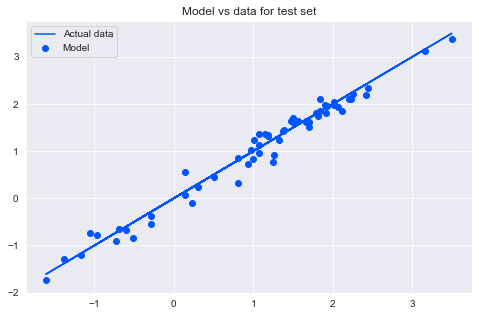

In [33]:
#Plot predictions for the test set against the actual data:
plt.figure(figsize=(8, 5))
plt.scatter(y_test, poly_test_predictions, label='Model')
plt.plot(y_test, y_test, label='Actual data')
plt.title('Model vs data for test set')
plt.legend();

Both train and test model are fitted well. 

# Interpretation 

The below features have the most impact when it comes to resale pricing for used cars: 

Age, Km driven, Seller Type and number of owners have a negative impacts on the price of used car, meaning that any increase in one of these features, will result in a decrease of the resale price of an used car. 

On the other hand, present price of the used car has a positive impact of the resale price, meaning that the higher the current price is, the higher the resale price will be. 


Model: 

The model R square is 0.973 - this mean that 97.3% of the resale price of an used car can be explained by the dependent variables in the model.

Mean square error (MSE) of the train test plit was improved after adding polynomial features into the data. Eventhough the difference between MSE train and test is 29%, both MSEs are quite low and close to 0. This suggests that the model has low level of error. 

In conclusion, the model is fitted quite well and can be used to predict the price highly accurately. 